# Sequence to Sequence Models for Timeseries Regression


In this notebook we are going to tackle a harder problem: 
- predicting the future on a timeseries
- using an LSTM
- with rough uncertainty (uncalibrated)
- outputing sequence of predictions

This gets you close to real world applications

Key learning objectives:
- Understand the LSTM's maintain a memory along sequences
- A rough overview of sequence to sequence approaches, and the data prep involved
- Understand likelihood and outputting a distribution
- Evalute a timeseries solution

<img src="./images/Seq2Seq_simple.png" />

In [1]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

## Parameters

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')

window_past = 48*4
window_future = 48*4
batch_size = 64
num_workers = 0
freq = '30T'
max_rows = 1e5
use_future = False # Cheat!

using cuda


## Load data

In [3]:

def get_smartmeter_df(indir=Path('../../data/processed/smartmeter')):
    """
    Data loading and cleanding is always messy, so understand this code is optional.
    """
    
    # Load csv files
    csv_files = sorted((indir/'halfhourly_dataset').glob('*.csv'))[:1]
    
    # concatendate them
    df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in csv_files])

    # Take the mean over all houses
    df = df.groupby('tstp').mean()

    # Load weather data
    df_weather = pd.read_csv(indir/'weather_hourly_darksky.csv', parse_dates=[3])
    use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
           'pressure', 'apparentTemperature', 'windSpeed', 
           'humidity']
    df_weather = df_weather[use_cols].set_index('time')
    df_weather = df_weather.resample(freq).ffill()  # Resample to match energy data    

    # Join weather and energy data
    df = pd.concat([df, df_weather], 1).dropna()    
    
    # Also find bank holidays
    df_hols = pd.read_csv(indir/'uk_bank_holidays.csv', parse_dates=[0])
    holidays = set(df_hols['Bank holidays'].dt.round('D'))  

    time = df.index.to_series()
    df['holiday'] = time.apply(lambda dt:dt.floor('D') in holidays).astype(int)

    # Add time features    
    df["month"] = time.dt.month
    df['day'] = time.dt.day
    df['week'] = time.dt.week
    df['hour'] = time.dt.hour
    df['minute'] = time.dt.minute
    df['dayofweek'] = time.dt.dayofweek

    # Drop nan and 0's
    df = df[df['energy(kWh/hh)']!=0]
    df = df.dropna()

    # sort by time
    df = df.sort_index()
    
    return df

Our dataset is the london smartmeter data. But at half hour intervals

In [4]:
df = get_smartmeter_df()

df = df.resample(freq).mean().dropna() # Where empty we will backfill, this will respect causality, and mostly maintain the mean

df = df.tail(int(max_rows)) # Just use last X rows
df

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
2011-12-03 09:00:00,0.149000,13.07,262.0,11.00,8.84,1002.07,11.00,5.99,0.87,0.0,12.0,3.0,48.0,9.0,0.0,5.0
2011-12-03 09:30:00,0.154000,13.07,262.0,11.00,8.84,1002.07,11.00,5.99,0.87,0.0,12.0,3.0,48.0,9.0,30.0,5.0
2011-12-03 10:00:00,0.768000,12.76,268.0,11.42,7.52,1002.76,11.42,6.10,0.77,0.0,12.0,3.0,48.0,10.0,0.0,5.0
2011-12-03 10:30:00,1.179000,12.76,268.0,11.42,7.52,1002.76,11.42,6.10,0.77,0.0,12.0,3.0,48.0,10.0,30.0,5.0
2011-12-03 11:00:00,0.588000,13.07,274.0,11.41,6.39,1003.24,11.41,6.20,0.71,0.0,12.0,3.0,48.0,11.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 22:00:00,0.678429,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84,0.0,2.0,27.0,9.0,22.0,0.0,3.0
2014-02-27 22:30:00,0.652071,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84,0.0,2.0,27.0,9.0,22.0,30.0,3.0
2014-02-27 23:00:00,0.545190,14.03,200.0,3.93,1.61,1004.62,1.42,2.75,0.85,0.0,2.0,27.0,9.0,23.0,0.0,3.0
2014-02-27 23:30:00,0.442571,14.03,200.0,3.93,1.61,1004.62,1.42,2.75,0.85,0.0,2.0,27.0,9.0,23.0,30.0,3.0


In [5]:
# Normalise
from sklearn.preprocessing import StandardScaler
input_columns = df.columns[1:]
out_columns = df.columns[:1]
scaler_input = StandardScaler()
scaler_output = StandardScaler()
df_norm = df.copy()
df_norm[input_columns] = scaler_input.fit_transform(df[input_columns])
df_norm[out_columns] = scaler_output.fit_transform(df[out_columns])
df_norm.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04,3.922500e+04
mean,-8.115313e-17,-9.187693e-16,-9.274643e-17,3.477991e-17,2.202728e-16,-2.388221e-15,1.970862e-16,6.955982e-17,6.955982e-17,3.767824e-17,4.057656e-17,-7.100899e-17,-5.796652e-17,-1.376705e-17,1.517376e-16,7.789251e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.946819e+00,-3.703458e+00,-2.173571e+00,-2.729647e+00,-3.206261e+00,-3.337412e+00,-2.552864e+00,-1.904117e+00,-3.921771e+00,-1.498985e-01,-1.456976e+00,-1.681277e+00,-1.548731e+00,-1.662307e+00,-9.999745e-01,-1.498470e+00
25%,-7.138837e-01,-3.127832e-01,-7.752553e-01,-6.974452e-01,-7.425864e-01,-5.816362e-01,-7.778616e-01,-7.383479e-01,-5.687687e-01,-1.498985e-01,-9.125645e-01,-8.830354e-01,-9.234714e-01,-7.953824e-01,-9.999745e-01,-9.986530e-01
50%,-5.885527e-02,3.425008e-01,2.376977e-01,-9.318589e-02,1.203535e-02,4.404180e-02,6.603837e-02,-1.064817e-01,2.159766e-01,-1.498985e-01,-9.594692e-02,2.924051e-02,-4.810793e-02,7.154198e-02,-9.999745e-01,9.811579e-04
75%,6.146349e-01,6.012539e-01,6.560913e-01,6.916760e-01,7.608374e-01,6.871725e-01,7.538168e-01,5.792647e-01,7.867005e-01,-1.498985e-01,9.928765e-01,8.274819e-01,8.897815e-01,9.384663e-01,1.000025e+00,1.000615e+00
max,6.994243e+00,1.612744e+00,1.779148e+00,3.691030e+00,2.586285e+00,2.559843e+00,3.255980e+00,5.325609e+00,1.571446e+00,6.671180e+00,1.537288e+00,1.739758e+00,1.640093e+00,1.660903e+00,1.000025e+00,1.500432e+00


In [6]:
# Resample
df_norm = df_norm.fillna(0)

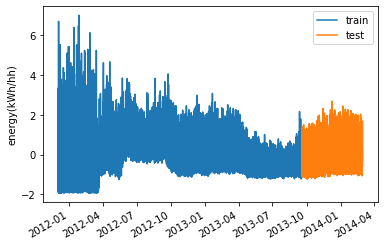

In [7]:
# split data
n_split = -int(len(df)*0.2)
df_train = df_norm[:n_split]
df_test = df_norm[n_split:]

# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.ylabel('energy(kWh/hh)')
plt.legend()

## Pytorch Dataset

A sequence to sequence model needs a sequence of inputs and a sequence of outputs. 

Lets use the pytorch dataset class to provide an array interface that makes these sequences on the fly

In the Dataset class we define a few methods:

- `__init__`: What information is required to create the object and how this information is saved.
- `__len__`: Returns the number of data points (images) when we use `len()` function.
- `__getitem__`: We can define how indexing would work for this class.

Out getitem returns:

- x_past: The past inputs
- y_past: The past labels
- x_future: (optional) The future inputs
- y_future: The labels

In [8]:
class SmartMeterSeq2SeqDataSet(torch.utils.data.Dataset):
    """
    Takes in dataframe and returns sequences through time.
    
    Returns x_past, y_past, x_future, etc.
    """
    
    def __init__(self, df, window_past=40, window_future=10, label_names=['energy(kWh/hh)']):
        self.x = df.drop(columns=label_names).copy().values
        self.y = df[label_names].copy().values
        self.t = df[label_names].index.copy()
        self.columns = list(df.columns)
        self.window_past = window_past
        self.window_future = window_future
        self.label_names = label_names

    def get_components(self, i):
        """Get  rows."""
        # Get past and future rows
        x = self.x[i : i + (self.window_past + self.window_future)].copy()
        y = self.y[i : i + (self.window_past + self.window_future)].copy()
        
        # Add a feature, relative days since present time
        tstp = (np.arange(len(x))-self.window_past)[:, None]
        is_past = tstp<0
        x = np.concatenate([x, tstp, is_past], -1)
        
        # Split into future and past
        x_past = x[:self.window_past]
        y_past = y[:self.window_past]
        x_future = x[self.window_past:]
        y_future = y[self.window_past:]
        if not use_future:
            # Stop it cheating by using future weather measurements
            x_future[:, :8]=0
        return x_past, y_past, x_future, y_future

    
    def get_rows(self, i):
        """
        A helper to put index and columns back on.
        
        We take them off originally for training speed
        """
        x_cols = list(self.columns)[1:] + ['tstp', 'is_past']
        x_past, y_past, x_future, y_future = self.get_components(i)
        t_past = self.t[i:i+self.window_past]
        t_future = self.t[i+self.window_past:i+self.window_past + self.window_future]
        x_past = pd.DataFrame(x_past, columns=x_cols, index=t_past)
        x_future = pd.DataFrame(x_future, columns=x_cols, index=t_future)
        y_past = pd.DataFrame(y_past, columns=self.label_names, index=t_past)
        y_future = pd.DataFrame(y_future, columns=self.label_names, index=t_future)
        return x_past, y_past, x_future, y_future


    def __getitem__(self, i):
        if i<0:
            # Handle negative integers
            i = len(self)+i
        data = self.get_components(i)
        # From dataframe to torch
        return [d.astype(np.float32) for d in data]
        
    def __len__(self):
        return len(self.x) - (self.window_past + self.window_future)
    
    def __repr__(self):
        return f'<{type(self).__name__}(df.shape={self.x.shape})>'

In [9]:
ds_train = SmartMeterSeq2SeqDataSet(df_train, window_past=window_past, window_future=window_future)
ds_test = SmartMeterSeq2SeqDataSet(df_test, window_past=window_past, window_future=window_future)
print(ds_train)
print(ds_test)

<SmartMeterSeq2SeqDataSet(df.shape=(31380, 15))>
<SmartMeterSeq2SeqDataSet(df.shape=(7845, 15))>


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek,tstp,is_past
2011-12-07 11:30:00,0.597893,0.788216,-0.331176,-0.915238,-0.597344,-0.663935,2.499354,-1.068152,-0.149899,1.537288,-0.99707,1.452515,-0.072945,1.000025,-0.498836,-5.0,1.0
2011-12-07 12:00:00,0.517243,0.854278,-0.255222,-1.182944,-0.561566,-0.609082,2.915700,-1.638876,-0.149899,1.537288,-0.99707,1.452515,0.071542,-0.999975,-0.498836,-4.0,1.0
2011-12-07 12:30:00,0.517243,0.854278,-0.255222,-1.182944,-0.561566,-0.609082,2.915700,-1.638876,-0.149899,1.537288,-0.99707,1.452515,0.071542,1.000025,-0.498836,-3.0,1.0
2011-12-07 13:00:00,0.597893,0.898319,-0.260286,-1.376934,-0.490882,-0.603456,2.754060,-1.924238,-0.149899,1.537288,-0.99707,1.452515,0.216029,-0.999975,-0.498836,-2.0,1.0
2011-12-07 13:30:00,0.597893,0.898319,-0.260286,-1.376934,-0.490882,-0.603456,2.754060,-1.924238,-0.149899,1.537288,-0.99707,1.452515,0.216029,1.000025,-0.498836,-1.0,1.0


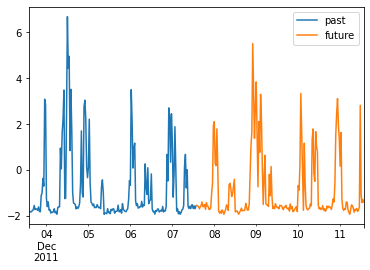

In [10]:
# We can get rows
x_past, y_past, x_future, y_future = ds_train.get_rows(10)

# Plot one instance, this is what the model sees
y_past['energy(kWh/hh)'].plot(label='past')
y_future['energy(kWh/hh)'].plot(ax=plt.gca(), label='future')
plt.legend()

# Notice we've added on two new columns tsp (time since present) and is_past
x_past.tail()

In [11]:
# Notice we've hidden some future columns to prevent cheating
x_future.tail()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek,tstp,is_past
2011-12-11 11:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149899,1.537288,-0.540932,1.452515,-0.072945,1.000025,1.500432,187.0,0.0
2011-12-11 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149899,1.537288,-0.540932,1.452515,0.071542,-0.999975,1.500432,188.0,0.0
2011-12-11 12:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149899,1.537288,-0.540932,1.452515,0.071542,1.000025,1.500432,189.0,0.0
2011-12-11 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149899,1.537288,-0.540932,1.452515,0.216029,-0.999975,1.500432,190.0,0.0
2011-12-11 13:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149899,1.537288,-0.540932,1.452515,0.216029,1.000025,1.500432,191.0,0.0


In [12]:
# and treat it like an array
print(len(ds_train))
ds_train[0][0].shape

30996


(192, 17)

 <div class="alert alert-success">
  <h2>Exercise: Dataset</h2>

  Lets understand the dataset by using it
    
  - get the 2nd to last element of the dataset
  - get the shape of each of the 4 returned elements of ds_train[0]
  - get the type of each of the 4 returned elements of ds_train[0]

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  ds_train[-2]
  print([x.shape for x in ds_train[0]])
  print([type(x) for x in ds_train[0]])
  ```

  </details>

  </div>

## LSTM: A minute of Theory

This is a hand on course, not theory so we will look at a high level view of one type of RNN, the LSTM. But lets look at the theory for a moment, to get some broad idea of how they work

The figure below is from d2l.ai and shows how an RNN can operate on a text sequence to predict the next charector.

![](images/rnn-train.svg)

How does the model itself work? Let look at an excerpt from the open source machine learning book [d2l.ai](d2l.ai):

![](images/rnn.svg)

> The figure below illustrates the computational logic of an RNN at three adjacent time steps. At any time step `t`, the computation of the hidden state can be treated as: 

> i) concatenating the input `Xt` at the current time step `t` and the hidden state `Ht−1` at the previous time step  `t−1` ; 

> ii) feeding the concatenation result into a fully-connected layer with the activation function `ϕ`. 

> The output of such a fully-connected layer is the hidden state  `Ht`  of the current time step  t . In this case, the model parameters are the concatenation of  `Wxh`  and  `Whh` , and a bias of  `bh`. The hidden state of the current time step  `t` , `Ht` , will participate in computing the hidden state  `Ht+1`  of the next time step  t+1 . What is more,  `Ht`  will also be fed into the fully-connected output layer to compute the output  `Ot`  of the current time step  `t` .

To understand more see these visualisations:

- [distill.pub memorization in rnns](memorization-in-rnns)
- [Chris Olah Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

And see these chapters:

- [d2l.ai RNN's](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html)
- [d2l.ai LSTM's](http://d2l.ai/chapter_recurrent-modern/lstm.html)


## Model

In [13]:

class Seq2SeqNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=32, lstm_layers=2, lstm_dropout=0, _min_std = 0.05):
        super().__init__()
        self._min_std = _min_std

        self.encoder = nn.LSTM(
            input_size=input_size + output_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.mean = nn.Linear(hidden_size, output_size)
        self.std = nn.Linear(hidden_size, output_size)

    def forward(self, past_x, past_y, future_x, future_y=None):
        past = torch.cat([past_x, past_y], -1)
        
        # Placeholder
        B, S, _ = future_x.shape
        future_y_fake = torch.zeros((B, S, 1)).to(device)

        future = torch.cat([future_x, future_y_fake], -1)
        x = torch.cat([past, future], 1).detach()
        
        outputs, _ = self.encoder(x)        
        
        # We only want the future
        outputs = outputs[:, -S:]
        
        # outputs: [B, T, num_direction * H]
        mean = self.mean(outputs)      
        
        log_sigma = self.std(outputs)
        log_sigma = torch.clamp(log_sigma, np.log(self._min_std), -np.log(self._min_std))

        sigma = torch.exp(log_sigma)
        y_dist = torch.distributions.Normal(mean, sigma)
        return y_dist


In [14]:

class Seq2SeqNet(nn.Module):
    def __init__(self, input_size, input_size_decoder, output_size, hidden_size=32, lstm_layers=2, lstm_dropout=0, _min_std = 0.05):
        super().__init__()
        self._min_std = _min_std

        self.encoder = nn.LSTM(
            input_size=input_size + output_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.decoder = nn.LSTM(
            input_size=input_size_decoder,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.mean = nn.Linear(hidden_size, output_size)
        self.std = nn.Linear(hidden_size, output_size)

    def forward(self, context_x, context_y, target_x, target_y=None):
        x = torch.cat([context_x, context_y], -1)
        _, (h_out, cell) = self.encoder(x)
        
        ## Shape
        # hidden = [batch size, n layers * n directions, hid dim]
        # cell = [batch size, n layers * n directions, hid dim]
        # output = [batch size, seq len, hid dim * n directions]
        outputs, (_, _) = self.decoder(target_x, (h_out, cell))
        
        
        # outputs: [B, T, num_direction * H]
        mean = self.mean(outputs)
        log_sigma = self.std(outputs)
        log_sigma = torch.clamp(log_sigma, np.log(self._min_std), -np.log(self._min_std))

        sigma = torch.exp(log_sigma)
        y_dist = torch.distributions.Normal(mean, sigma)
        return y_dist



In [17]:
input_size = x_past.shape[-1]
output_size = y_future.shape[-1]

model = Seq2SeqNet(input_size, input_size, output_size,
                   hidden_size=32, 
                   lstm_layers=2, 
                   lstm_dropout=0).to(device)
model

Seq2SeqNet(
  (encoder): LSTM(18, 32, num_layers=2, batch_first=True)
  (decoder): LSTM(17, 32, num_layers=2, batch_first=True)
  (mean): Linear(in_features=32, out_features=1, bias=True)
  (std): Linear(in_features=32, out_features=1, bias=True)
)

In [18]:
# Init the optimiser
optimizer = optim.Adam(model.parameters(), lr=1e-3)

 <div class="alert alert-success">
  <h2>Exercise: Model</h2>

  To understand the model we first need to understand the inputs and outputs.
    
  * Make fake data of the correct shape, and pass it into the model.
  * What is the data type of the output?
    
  ```python
  past_x, past_y, future_x, future_y
  output = model(?)
  print(output)
  ```
      

  <details>
  <summary><b>→ Hints</b></summary>

  * One
  * Two

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    past_x = torch.rand((batch_size, window_past, input_size)).to(device)
    future_x = torch.rand((batch_size, window_future, input_size)).to(device)
    past_y = torch.rand((batch_size, window_past, output_size)).to(device)
    future_y = torch.rand((batch_size, window_future, output_size)).to(device)
    output = model(past_x, past_y, future_x, future_y)  
    print(output)
  ```

  </details>

  </div>

## Concept: Likelihood

In this notebook we wont just predict an answer, but how wrong we might be: the mean and standard deviation.

So instead of the mean squared error, like in most regression problems, we are going to be predicting a normal distribution, and minimising the [Negative Log Likihood (NLL)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 

This means our model will output a distribution, and we will try to make sure it overlaps with the true answer as much possible. This is the concept of likelihood, which is illustrated below.

The image below shows a distribution in blue, then possible answers in red.

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


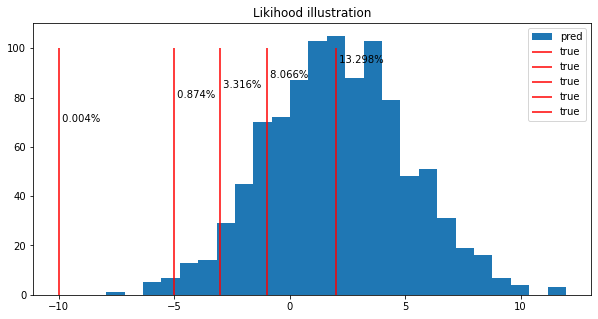

In [19]:
# Here is out distribution
y_dist = torch.distributions.Normal(loc=2, scale=3)
# We can sample from it. Lets see the predictions:
n = y_dist.sample_n(1000).numpy()

# We can also get the probability of an answer being sampled from the distribution
y_dist.log_prob(2).exp() # log and exp cancel out

plt.figure(figsize=(10, 5))
plt.title('Likihood illustration')
plt.hist(n, bins=25, label='pred')
for y_true in [-10, -5, -3, -1, 2]:
    prob = y_dist.log_prob(y_true).exp().numpy()
    plt.vlines(x=y_true, ymin=0, ymax=100, color='r', label=f'true')
    plt.text(x=y_true, y=90+y_true*2, s=f'{prob: 3.3%}')
plt.legend()
plt.show()

 <div class="alert alert-success">
  <h2>Exercise Likelihood</h2>

  If you have a normal distribution with mean 1 and std 3. What is the liklihood of 2?
    
    
      

  <details>
  <summary><b>→ Hints</b></summary>

  * `y_dist = torch.distributions.Normal(?, ?)`
  * `print(y_dist.log_prob(?).exp())`

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  y_dist = torch.distributions.Normal(1, 3)
  print(y_dist.log_prob(2).exp())
  ```

  </details>

  </div>

## Training

In [20]:
def to_numpy(x):
    """Helper function to avoid repeating code"""
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

In [21]:
def train_epoch(ds, model, bs=128):
    model.train()

    training_loss = []

    # Put data into a torch loader
    load_train = torch.utils.data.dataloader.DataLoader(
        ds,
        batch_size=bs,
        pin_memory=False,
        num_workers=num_workers,
        shuffle=True,
    )

    for batch in tqdm(load_train, leave=False, desc='train'):
        # make it a pytorch gpu variable
        x_past, y_past, x_future, y_future = [d.to(device) for d in batch]

        optimizer.zero_grad()
        y_dist = model(x_past, y_past, x_future, y_future)
        loss = -y_dist.log_prob(y_future).mean()

        # Backprop
        loss.backward()
        optimizer.step()

        # Record stats
        training_loss.append(loss.item())

    return np.mean(training_loss)


def test_epoch(ds, model, bs=512):
    model.eval()

    test_loss = []
    load_test = torch.utils.data.dataloader.DataLoader(ds,
                                                       batch_size=bs,
                                                       pin_memory=False,
                                                       num_workers=num_workers)
    for batch in tqdm(load_test, leave=False, desc='test'):
        x_past, y_past, x_future, y_future = [d.to(device) for d in batch]
        with torch.no_grad():
            y_dist = model(x_past, y_past, x_future, y_future)
            loss = -y_dist.log_prob(y_future).mean()

        test_loss.append(loss.item())

    return np.mean(test_loss)


def training_loop(ds_train, ds_test, model, epochs=1, bs=128):
    all_losses = []
    try:
        test_loss = test_epoch(ds_test, model)
        print(f"Start: Test Loss = {test_loss:.2f}")
        for epoch in tqdm(range(epochs), desc='epochs'):
            loss = train_epoch(ds_train, model, bs=bs)
            print(f"Epoch {epoch+1}/{epochs}: Training Loss = {loss:.2f}")

            test_loss = test_epoch(ds_test, model)
            print(f"Epoch {epoch+1}/{epochs}: Test Loss = {test_loss:.2f}")
            print("-" * 50)

            all_losses.append([loss, test_loss])

    except KeyboardInterrupt:
        # This lets you stop manually. and still get the results
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()

    return all_losses

Start: Test Loss = 1.27


Epoch 1/8: Training Loss = 0.83


Epoch 1/8: Test Loss = 0.10
--------------------------------------------------


Epoch 2/8: Training Loss = 0.45


Epoch 2/8: Test Loss = 0.18
--------------------------------------------------


Epoch 3/8: Training Loss = 0.42


Epoch 3/8: Test Loss = 0.06
--------------------------------------------------


Epoch 4/8: Training Loss = 0.32


Epoch 4/8: Test Loss = 0.20
--------------------------------------------------


Epoch 5/8: Training Loss = 0.33


Epoch 5/8: Test Loss = 0.07
--------------------------------------------------


Epoch 6/8: Training Loss = 0.31


Epoch 6/8: Test Loss = 0.13
--------------------------------------------------


Epoch 7/8: Training Loss = 0.26


Epoch 7/8: Test Loss = 0.15
--------------------------------------------------


1

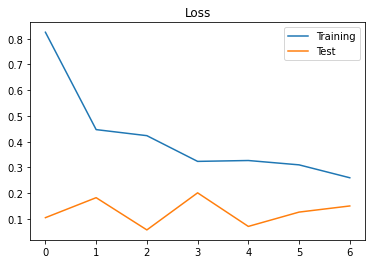

In [22]:
# this might take 1 minute per epoch on a gpu
training_loop(ds_train, ds_test, model, epochs=8, bs=batch_size)
1

## Predict

When we generate prediction in a sequence to sequence model we start at a time, then predict N steps into the future. So we have 2 dimensions: source time, target time.

But we also care about how far we were predicting into the future, so we have 3 dimensions: source time, target time, time ahead.

It's hard to use pandas for data with more than 2 dimensions, so we will use xarray. Xarray has an interface similar to pandas but can have N dimensions.

In [23]:
import xarray as xr 

def predict(model, ds_test, batch_size):
    load_test = torch.utils.data.dataloader.DataLoader(ds_test, batch_size=batch_size)
    xrs = []
    for i, batch in enumerate(tqdm(load_test, desc='predict')):
        model.eval()
        with torch.no_grad():
            x_past, y_past, x_future, y_future = [d.to(device) for d in batch]
            y_dist = model(x_past, y_past, x_future, y_future)
            nll = -y_dist.log_prob(y_future)

            # Convert to numpy
            mean = to_numpy(y_dist.loc.squeeze(-1))
            std = to_numpy(y_dist.scale.squeeze(-1))
            nll = to_numpy(nll.squeeze(-1))
            y_future = to_numpy(y_future.squeeze(-1))
            y_past = to_numpy(y_past.squeeze(-1))    

        # Make an xarray.Dataset for the data
        bs = y_future.shape[0]
        t_source = ds_test.t[i:i+bs].values
        t_ahead = pd.timedelta_range(0, periods=ds_test.window_future, freq=freq).values
        t_behind = pd.timedelta_range(end=-pd.Timedelta(freq), periods=ds_test.window_past, freq=freq)
        xr_out = xr.Dataset(
            {
                # Format> name: ([dimensions,...], array),
                "y_past": (["t_source", "t_behind",], y_past),
                "nll": (["t_source", "t_ahead",], nll),
                "y_pred": (["t_source", "t_ahead",], mean),
                "y_pred_std": (["t_source", "t_ahead",], std),
                "y_true": (["t_source", "t_ahead",], y_future),
            },
            coords={"t_source": t_source, "t_ahead": t_ahead, "t_behind": t_behind},
        )
        xrs.append(xr_out)

    # Join all batches
    ds_preds = xr.concat(xrs, dim="t_source")
    
    # undo scaling on y
    ds_preds['y_pred_std'].values = ds_preds.y_pred_std * scaler_output.scale_
    ds_preds['y_past'].values =  scaler_output.inverse_transform(ds_preds.y_past)
    ds_preds['y_pred'].values =  scaler_output.inverse_transform(ds_preds.y_pred)
    ds_preds['y_true'].values =  scaler_output.inverse_transform(ds_preds.y_true)
    
    # Final metric, mean NLL for up to 6 hours ahead
    test_NLL = ds_preds.isel(t_ahead=slice(0, 12)).nll.mean().item()
    print(f'NLL mean over <=6 hours: {test_NLL:2.4g} (lower is better)')
    return ds_preds

In [24]:
ds_preds = predict(model, ds_test, batch_size*6)


NLL mean over <=6 hours: 0.09597 (lower is better)


In [25]:
# Add some derived coordinates, they will be the ones not in bold
# The target time, is a function of the source time, and how far we predict ahead
ds_preds = ds_preds.assign_coords(t_target=ds_preds.t_source+ds_preds.t_ahead)

ds_preds = ds_preds.assign_coords(t_past=ds_preds.t_source+ds_preds.t_behind)

# Some plots don't like timedeltas, so lets make a coordinate for time ahead in hours
ds_preds = ds_preds.assign_coords(t_ahead_hours=(ds_preds.t_ahead*1.0e-9/60/60).astype(float))

ds_preds

<xarray.Dataset>
Dimensions:        (t_ahead: 192, t_behind: 192, t_source: 7461)
Coordinates:
  * t_source       (t_source) datetime64[ns] 2013-09-17T14:00:00 ... 2013-09-...
  * t_ahead        (t_ahead) timedelta64[ns] 00:00:00 ... 3 days 23:30:00
  * t_behind       (t_behind) timedelta64[ns] -4 days +00:00:00 ... -1 days +...
    t_target       (t_source, t_ahead) datetime64[ns] 2013-09-17T14:00:00 ......
    t_past         (t_source, t_behind) datetime64[ns] 2013-09-13T14:00:00 .....
    t_ahead_hours  (t_ahead) float64 0.0 0.0 1.0 1.0 2.0 ... 94.0 94.0 95.0 95.0
Data variables:
    y_past         (t_source, t_behind) float32 0.34478724 ... 0.42559525
    nll            (t_source, t_ahead) float32 0.4811635 ... -0.26418364
    y_pred         (t_source, t_ahead) float32 0.39915967 ... 0.4406219
    y_pred_std     (t_source, t_ahead) float64 0.04404 0.04372 ... 0.06705
    y_true         (t_source, t_ahead) float32 0.46641305 ... 0.44257143

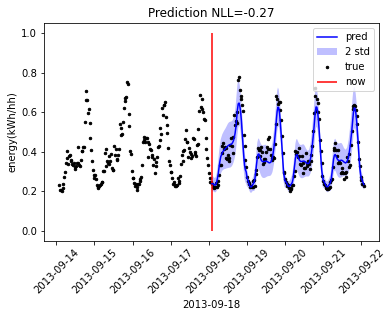

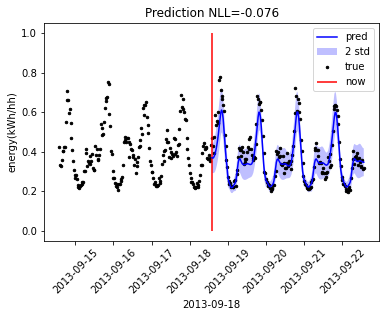

In [35]:
def plot_prediction(ds_preds, i):
    """Plot a prediction into the future, at a single point in time."""
    d = ds_preds.isel(t_source=i)

    # Get arrays
    xf = d.t_target
    yp = d.y_pred
    s = d.y_pred_std
    yt = d.y_true
    now = d.t_source.squeeze()

    # plot prediction
    plt.fill_between(xf, yp-2*s, yp+2*s, alpha=0.25,
            facecolor="b",
            interpolate=True,
            label="2 std",)
    plt.plot(xf, yp, label='pred', c='b')

    # plot true
    plt.scatter(
        d.t_past,
        d.y_past,
        c='k',
        s=6
    )
    plt.scatter(xf, yt, label='true', c='k', s=6)
    
    # plot a red line for now
    plt.vlines(x=now, ymin=0, ymax=1, label='now', color='r')

    now=pd.Timestamp(now.values)
    plt.title(f'Prediction NLL={d.nll.mean().item():2.2g}')
    plt.xlabel(f'{now.date()}')
    plt.ylabel('energy(kWh/hh)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
# plot_prediction(ds_preds, 0) 
# plot_prediction(ds_preds, 12) # 6 hours later
plot_prediction(ds_preds, 24) # 12 hours later
plot_prediction(ds_preds, 48) # 12 hours later

## Error vs time ahead

Text(0.5, 1.0, 'NLL vs time (no. samples=7461)')

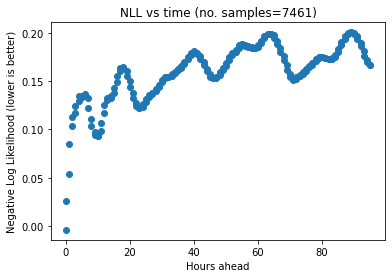

In [28]:
d = ds_preds.mean('t_source') # Mean over all predictions

# Plot with xarray, it has a pandas like interface
d.plot.scatter('t_ahead_hours', 'nll')

# Tidy the graph
n = len(ds_preds.t_source)
plt.ylabel('Negative Log Likelihood (lower is better)')
plt.xlabel('Hours ahead')
plt.title(f'NLL vs time (no. samples={n})')

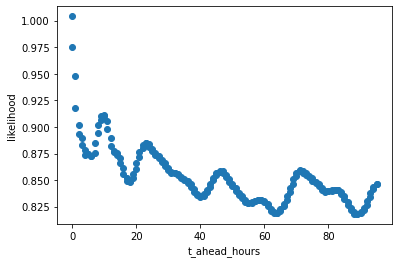

In [29]:
d = ds_preds.mean('t_source') # Mean over all predictions
d['likelihood'] = np.exp(-d.nll) # get likelihood, after taking mean in log domain
d.plot.scatter('t_ahead_hours', 'likelihood')

 <div class="alert alert-success">
  <h2>Exercise Xarray Scatter Plot</h2>

  Lets try out xarray. Many people like seeing a plot of y_true vs y_pred.
    
  1. Make a plot of y_true vs y_pred
  2. (hard) Make a plot of the NLL over time. Does this solution get worse with time?
      

  <details>
  <summary><b>→ Hints</b></summary>

  * The interface is similar to pandas
  * Fill in the columns here: `ds_preds.plot.scatter(?, ?, s=2)`
  * Take the mean over t_ahead

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  # This is easy with xarray
  ds_preds.plot.scatter('y_true', 'y_pred', s=2)
  ```

  </details>

  </div>

 <div class="alert alert-success">
  <h2>(hard) Exercise: Loss vs Time plot</h2>

  Solutions typically decay in usefullness with time, and can require retraining. Does this one?
    
  2. Make a plot of the NLL over time. Does this solution get worse with time?
      

  <details>
  <summary><b>→ Hints</b></summary>

  * Take the mean over t_ahead
  * group by t_source

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  
  # this is hard because we need to take the mean over t_ahead
  # then group by t_source
  d = ds_preds.mean('t_ahead').groupby('t_source').mean()
  # And even then it's clearer with smoothing
  d.plot.scatter('t_source', 'nll')
  plt.xticks(rotation=45)
  plt.title('NLL over time (lower is better)')
  1
  ```

  </details>

  </div>